In [1]:
import torch
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve

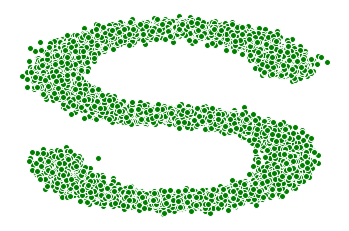

In [2]:
s_curve, _ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0,2]] / 10.0          # (10000, 2)

data = s_curve.T
fig, ax = plt.subplots()
ax.scatter(*data, color ='green', edgecolor='white')
ax.axis('off')

dataset = torch.Tensor(s_curve).float()

### 1. Confirm hyperparameters

In [3]:
num_steps = 100

# 制定每一步的beta
betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

# 计算alpha, alpha_prod, alpha_prod_previous, alpha_bar_sqrt 等变量
alphas = 1-betas
alphas_prod = torch.cumprod(alphas, 0)  # 累乘
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0) # Previous step
alphas_bar_sqrt = torch.sqrt(alphas_prod)

one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == \
    alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape == one_minus_alphas_bar_sqrt.shape

print('All the same shape:', betas.shape)


All the same shape: torch.Size([100])


### 2. 确定扩散过程任意时刻的采样

In [4]:
# 计算任意时刻x的采样值， 基于 x_0 和 reparameterization trick
def q_x(x_0, t):
    """可以基于x[0] 得到任意时刻t的x[t]"""
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]

    return (alphas_t * x_0 + alphas_1_m_t * noise) # 在x[0]添加基础噪声

### 3. 原始分布加噪声100步

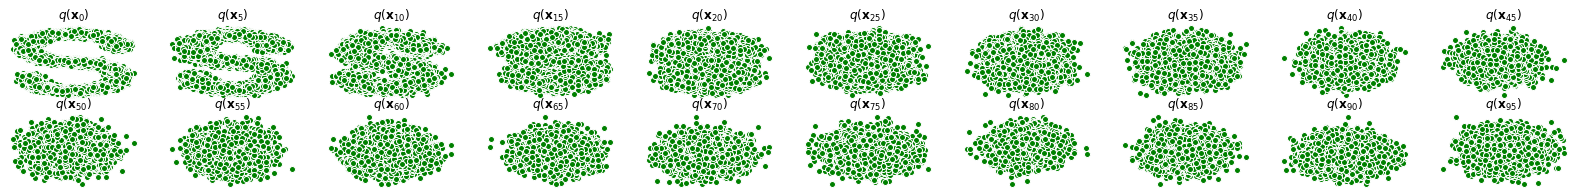

In [5]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='blue')

# 10000 samples
# plot every 5 steps
for i in range(num_shows):
    
    j = i//10
    k = i%10
    q_i = q_x(dataset, torch.tensor([i*num_steps//num_shows])) # generate at t-step
    axs[j, k].scatter(q_i[:,0], q_i[:, 1], color = 'green', edgecolor='white')

    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{' + str(i * num_steps // num_shows) + '})$')

### 4. 编写拟合逆扩散过程高斯分布的模型

In [21]:
import torch
import torch.nn as nn

class Diffusion(nn.Module):

    def __init__(self, n_steps, num_units=128):
        super(Diffusion, self).__init__()

        self.linears = nn.ModuleList(
           [
            nn.Linear(2, num_units),
            nn.ReLU(),
            nn.Linear(num_units, num_units),
            nn.ReLU(),
            nn.Linear(num_units, num_units),
            nn.ReLU(),
            nn.Linear(num_units, 2)
           ]
        )

        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units)
            ]
        )

    def forward(self, x, t):
        
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
        
        x = self.linears[-1](x)
        return x

### 5. 编写损失函数

In [22]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):

    '''对任意时刻t进行采样计算loss'''
    batch_size = x_0.shape[0]

    # 随机采样一个时刻t，为了提高训练效率，t 不重复
    t = torch.randint(0, n_steps, size=(batch_size//2,))
    t = torch.cat([t, n_steps-1-t], dim=0)
    t = t.unsqueeze(-1)

    # x_0 的系数
    a = alphas_bar_sqrt[t]

    # eps/z 的系数
    am1 = one_minus_alphas_bar_sqrt[t]

    # 生成随机噪音 eps/z
    e = torch.randn_like(x_0)

    # 模型输入
    x = x_0 * a +  e * am1

    # 送入模型，得到t时刻的随机噪声预测值
    output= model(x, t.squeeze(-1))

    return (e-output).square().mean()


### 6. 逆扩散采样函数(inference)

In [23]:
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """从 x[T] 恢复到x[T-1], x[T-2]...."""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x,i,betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    """从 x[T] 采样t时刻的重构值"""
    t = torch.tensor([t])

    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]

    eps_theta = model(x,t)

    mean = (1 / (1-betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()

    sample = mean + sigma_t * z

    return (sample)

### 7. 开始训练模型，打印loss和效果

Training model...
tensor(0.5562, grad_fn=<MeanBackward0>)
tensor(0.4791, grad_fn=<MeanBackward0>)
tensor(0.4424, grad_fn=<MeanBackward0>)
tensor(0.3495, grad_fn=<MeanBackward0>)
tensor(0.2740, grad_fn=<MeanBackward0>)
tensor(0.6451, grad_fn=<MeanBackward0>)
tensor(0.4379, grad_fn=<MeanBackward0>)
tensor(0.3876, grad_fn=<MeanBackward0>)
tensor(0.5236, grad_fn=<MeanBackward0>)
tensor(0.3192, grad_fn=<MeanBackward0>)
tensor(0.2998, grad_fn=<MeanBackward0>)
tensor(0.3716, grad_fn=<MeanBackward0>)
tensor(0.3823, grad_fn=<MeanBackward0>)
tensor(0.3555, grad_fn=<MeanBackward0>)
tensor(0.1006, grad_fn=<MeanBackward0>)
tensor(0.4159, grad_fn=<MeanBackward0>)
tensor(0.4825, grad_fn=<MeanBackward0>)
tensor(0.4622, grad_fn=<MeanBackward0>)
tensor(0.5504, grad_fn=<MeanBackward0>)
tensor(0.2763, grad_fn=<MeanBackward0>)
tensor(0.6603, grad_fn=<MeanBackward0>)


/tmp/ipykernel_2467181/1370923716.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 10, figsize=(28,4))


tensor(0.1986, grad_fn=<MeanBackward0>)
tensor(0.3004, grad_fn=<MeanBackward0>)
tensor(0.2607, grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

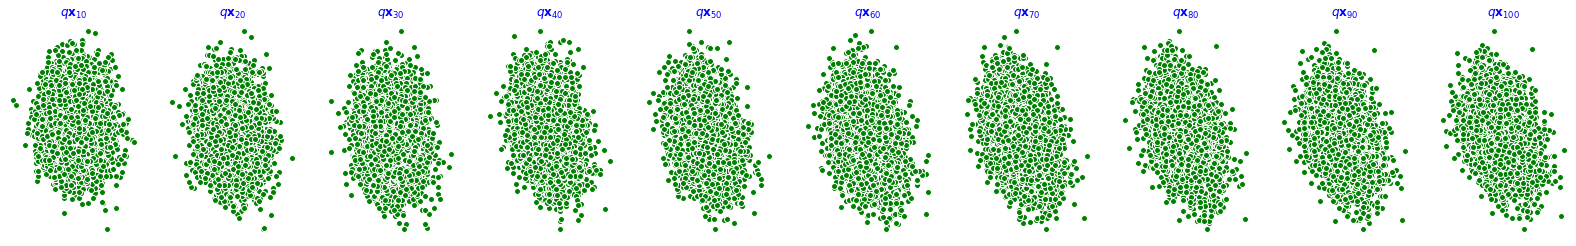

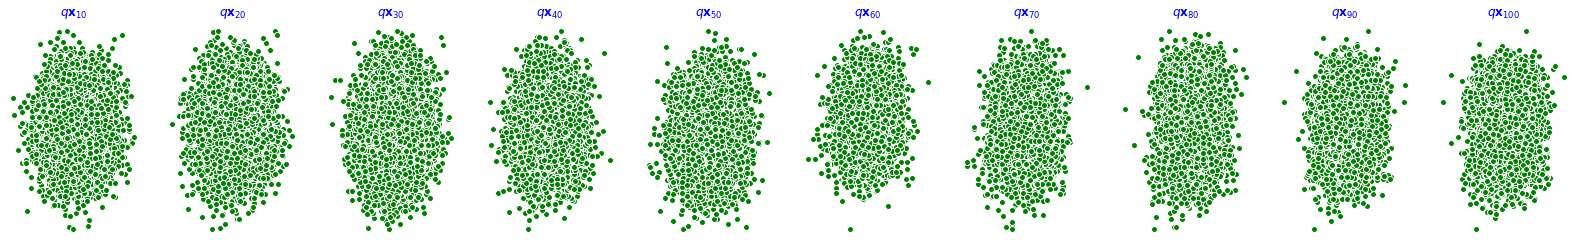

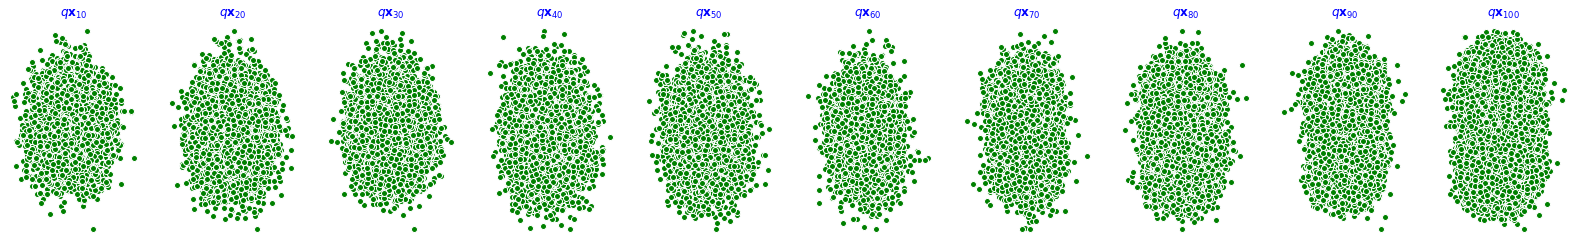

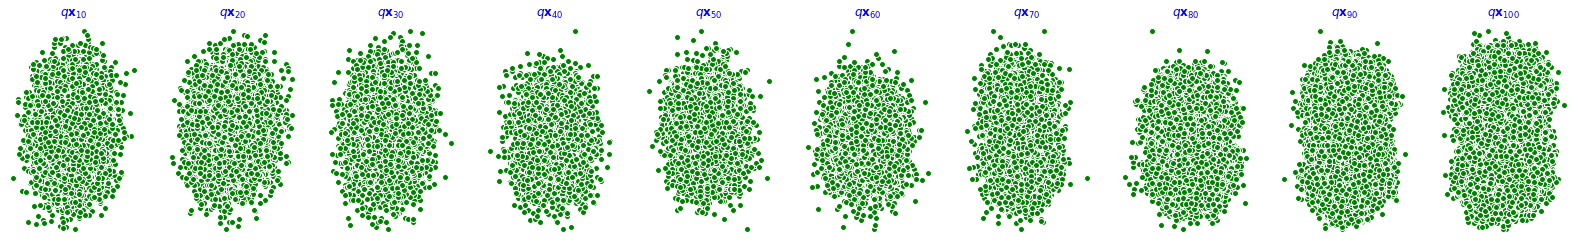

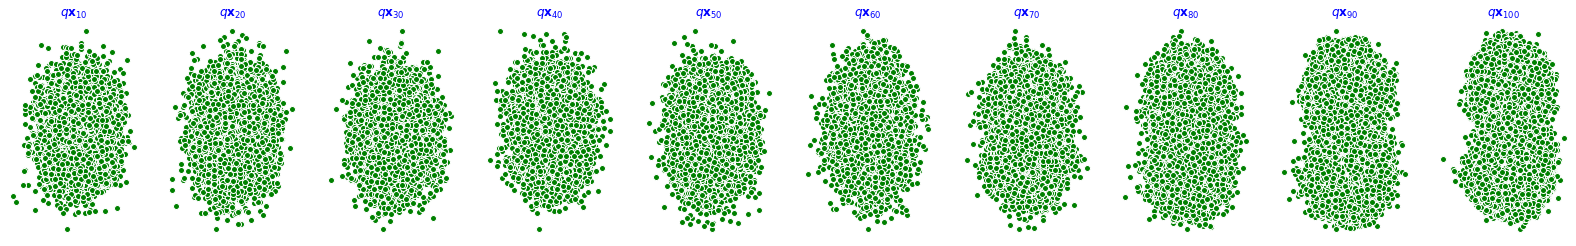

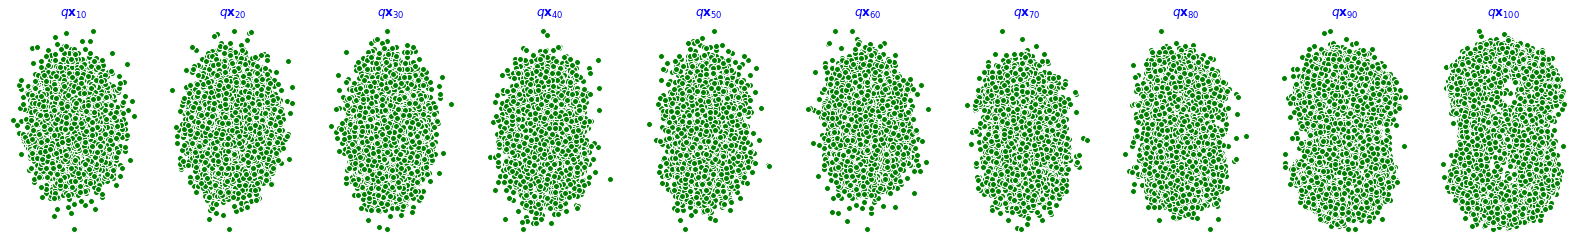

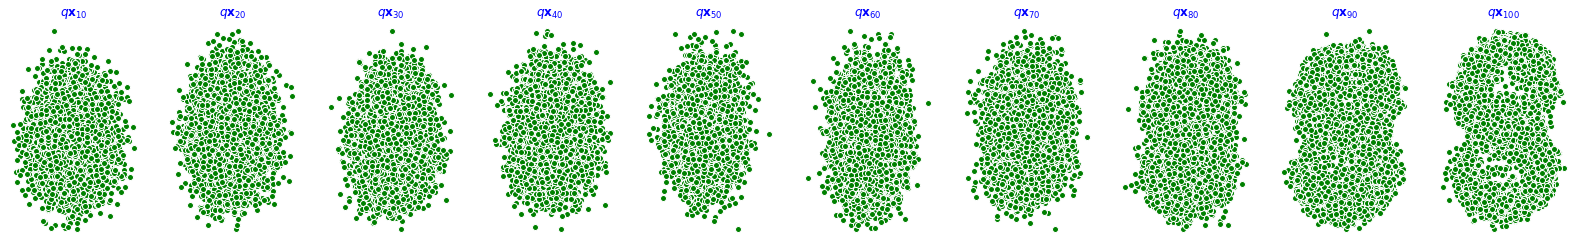

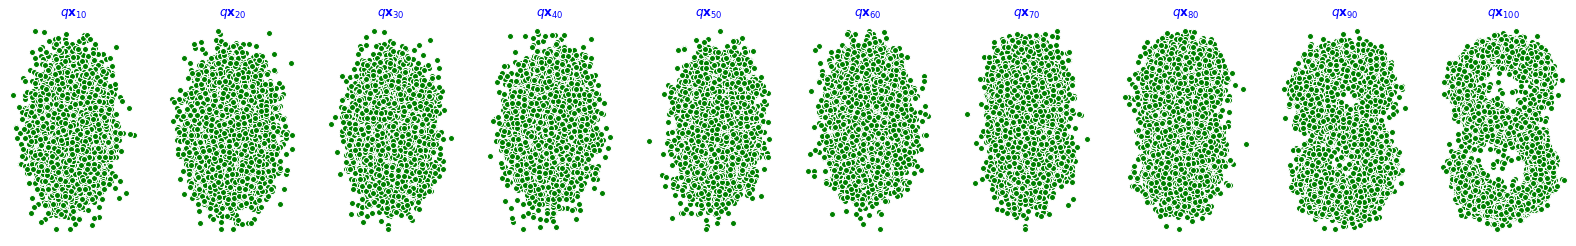

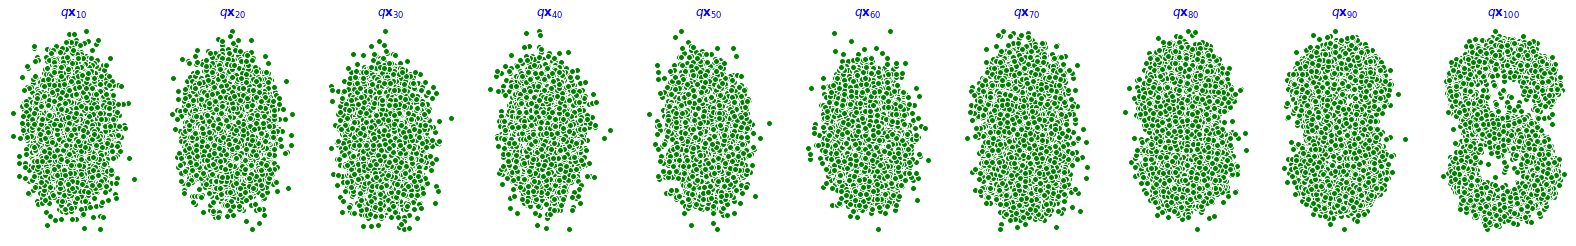

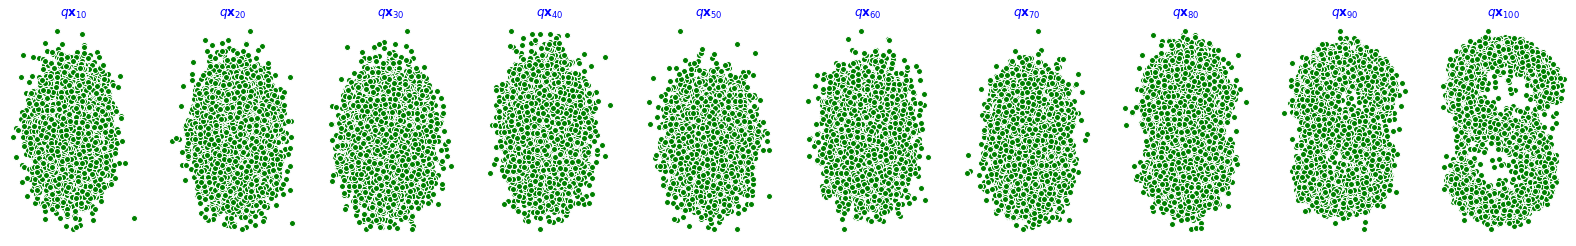

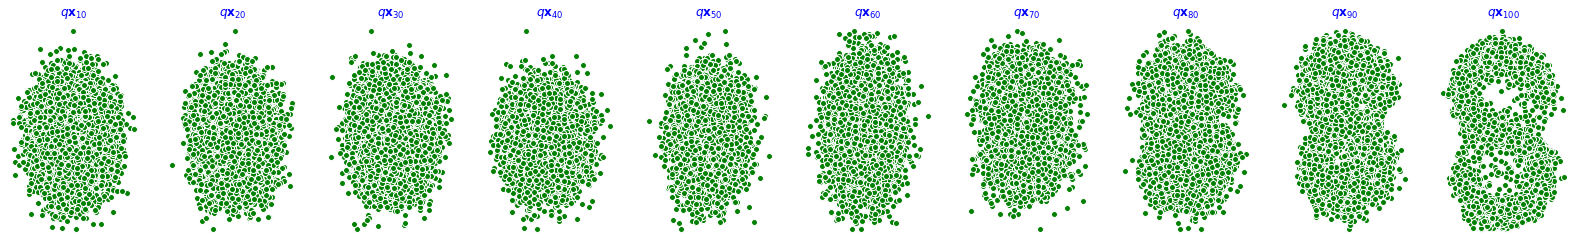

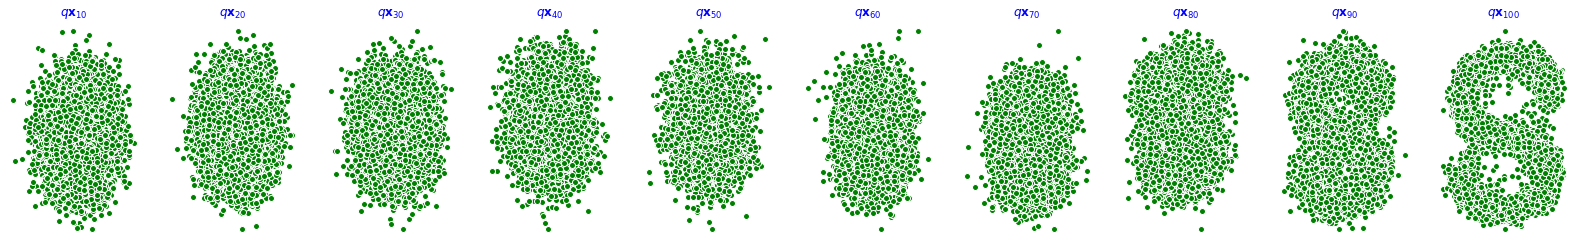

Error in callback <function flush_figures at 0x7f2067b614c0> (for post_execute):


KeyboardInterrupt: 

In [25]:
seed = 1234

class EMA():
    """参数平滑"""
    def __init__(self, mu=0.01):
        self.mu = mu
        self.shadow = {}
    
    def register(self, name, val):
        self.shadow[name] = val.clone()
    
    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average

print("Training model...")

'''
ema = EMA(0.5)
for name, param in model.named_parameters():
    if param.requires_grad:
        ema.register(name, param.data)
'''

batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text', color='blue')

model = Diffusion(num_steps) # output size is 2, inputs are x and num_step
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

        # for name, param in model.named_parameters():
        #   if param.requires_grad:
        #       param.data = ema(name, param.data)
    
    # print(loss)
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt) # 100 个元素

        fig, axs = plt.subplots(1, 10, figsize=(28,4))
        for i in range(1,11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:,0], cur_x[:,1], color='green', edgecolor='white');
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q{\mathbf{x}_{' + str(i*10) + '}}$')